In [108]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from openpyxl.drawing.image import Image

%matplotlib inline

In [97]:
sns.set(font='IPAEXGothic')

## データを作る

In [98]:
data_size = 500
df = pd.DataFrame(data={
    'rank': np.floor(np.random.normal(10, 3, data_size)),
    'value': np.random.normal(0, 5, data_size),
})
df.head()

,rank,value
0,6.0,-5.660920
1,5.0,-1.405914
2,10.0,-3.495801
3,8.0,-0.874792
4,7.0,1.967860


## データフレームからヒストグラムを表示

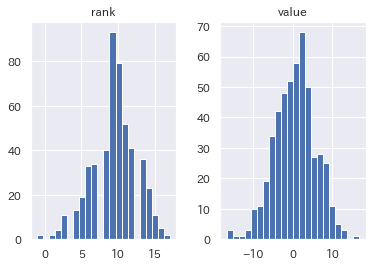

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2)
subplots = df.hist(ax=ax, bins=int(np.sqrt(data_size)))
fig.savefig('./dist/hist.png')

## 一つだけヒストグラムを表示

### Pandas経由

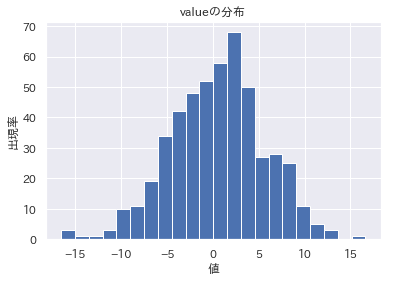

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1)
subplots = df.hist(column='value', ax=ax, bins=int(np.sqrt(data_size)))
ax.set_title('valueの分布')
ax.set_ylabel('出現率')
ax.set_xlabel('値')
fig.savefig('./dist/hist_value_pandas.png')

### Seaborn経由

c:\users\delta\.virtualenvs\exceleditorenv-u9juyecq\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


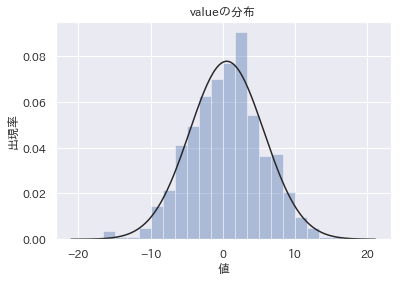

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.distplot(df['value'].values, kde=False, fit=stats.norm, ax=ax)
ax.set_title('valueの分布')
ax.set_ylabel('出現率')
ax.set_xlabel('値')
fig.savefig('./dist/hist_value_seaborn.png')

### 平均、分散の取得

In [107]:
mean = df['value'].values.mean()
var = df['value'].values.var()
mean, var

(0.5409710120404334, 26.363147249578596)

## エクセルファイルへ画像を貼り付け

In [103]:
excel_path = './dist/histogram.xlsx'
df.to_excel(excel_path)

In [109]:
wb = openpyxl.load_workbook(excel_path)
ws = wb.active
img = Image('./dist/hist_value_pandas.png')
ws.add_image(img, 'A1')
wb.save(excel_path)